# **Finding Lane Lines on the Road** 
***
Samuel Rustan

samrustan@gmail.com

January 2017 cohort

This submission is for Project 1 of the Self Driving Course at Udacity.
The project is to paint solid, rigid lane lines for the given images and video.


**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
%matplotlib inline

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

#calculate slope
def calc_m(x1,y1,x2,y2):
    return ((y2-y1)/(x2-x1))

#calculate line center
def calc_center(x1,y1,x2,y2):
    return [((x2+x1)/2),((y2+y1)/2)]

def draw_lines(img, lines, color=[255, 0, 0], thickness=5):
    """
    1) determine slope and classify points by right or left
    
    2) find end-points of line
    
    3) average line data
    
    4) calculate b-intercept from averaged data
    
    5) calculate new x and y points to be drawn using averaged data 
    
    6) draw lines 
    """
    
    slope_left = []
    slope_left_avg = []
    slope_right = []
    slope_right_avg = []
    lane_left = []
    lane_right = []
    center_left = []
    center_right = []
    slope_cutoff = 0.5
    current_frame = []
    global prev_frame
    global frame_init
    
    
    for line in lines:
        #use this for loop to separate and collect points
        for x1,y1,x2,y2 in line:
            slope = calc_m(x1,y1,x2,y2)
            
            if slope > slope_cutoff:
                slope_right.append(slope)
                #right lane points
                if(len(line) == 0):
                    break
                else:    
                    lane_right.append(line)
                    center_right = calc_center(x1,y1,x2,y2)
                    
            if slope < -slope_cutoff:
                slope_left.append(slope)
                #left lane points
                if(len(line) == 0):
                    break
                else:    
                    lane_left.append(line)
                    center_left = calc_center(x1,y1,x2,y2)
        
        #end-points for each line
        y_min = 0.6 * img.shape[0]
        y_max = img.shape[0]
    

    #calculate averages
    try: 
        slope_left_avg = sum(slope_left)/len(slope_left)
        slope_right_avg = sum(slope_right)/len(slope_right)

    except ZeroDivisionError:
        pass
    
    
    try: 
        lane_left_avg = sum(lane_left)/len(lane_left)
        lane_right_avg = sum(lane_right)/len(lane_right)

    except ZeroDivisionError:
        pass
    
    #now with the lane points averaged

    try: 
        b_left = center_left[1] - (slope_left_avg * center_left[0])
        b_right = center_right[1] - (slope_right_avg * center_right[0])
        
    except IndexError:
        b_left = 0
        b_right = 0
    
    #calculate x points from avergaged data using x = (y-b)/m
    left_x1 = np.array(y_min - b_left)/slope_left_avg
    left_x2 = np.array(y_max - b_left)/slope_left_avg
    right_x1 = np.array(y_min - b_right)/slope_right_avg
    right_x2 = np.array(y_max - b_right)/slope_right_avg
    
    #calculate y points from averaged data using y = mx + b
    left_y1 = slope_left_avg*left_x1 + b_left
    left_y2 = slope_left_avg*left_x2 + b_left
    right_y1 = slope_right_avg*right_x1 + b_right
    right_y2 = slope_right_avg*right_x2 + b_right
  
 
    #put all points into an array to cleanly designate between current_frame and next_frame
    current_frame = np.array([left_x1,left_y1,left_x2,left_y2,right_x1,right_y1,right_x2,right_y2],dtype="float32")

    if frame_init == 1:
        prev_frame = current_frame
        frame_init = 0
    
    if np.any(current_frame) == 0:
        current_frame = prev_frame
    
    frame = (current_frame + prev_frame)/2

    cv2.line(img, (frame[0],frame[1]),(frame[2],frame[3]), color, thickness)
    cv2.line(img, (frame[4],frame[5]),(frame[6],frame[7]), color, thickness)
    
    prev_frame = frame

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

(run your solution on all test_images and make copies into the test_images directory).

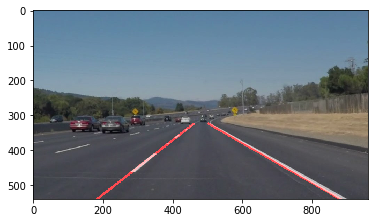

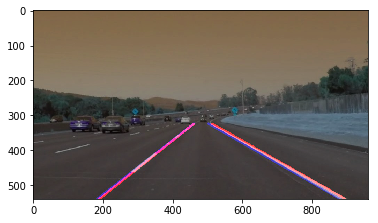

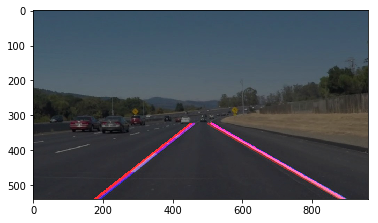

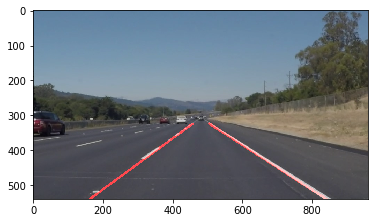

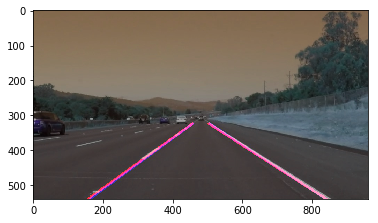

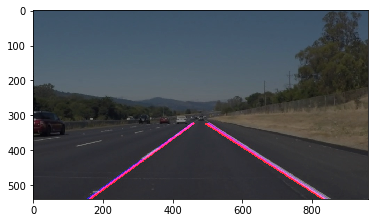

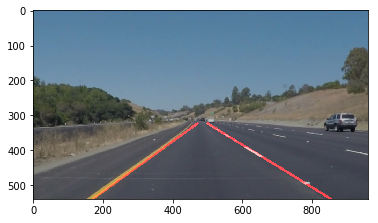

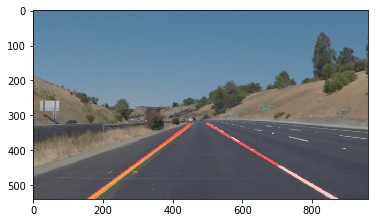

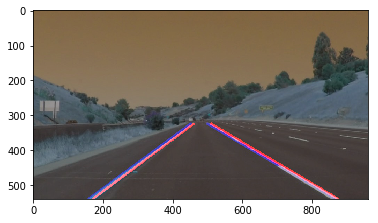

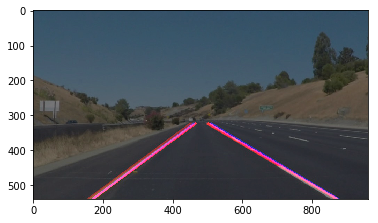

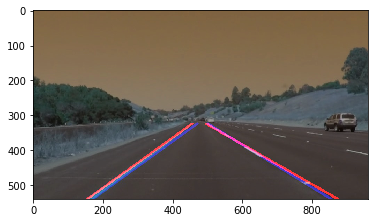

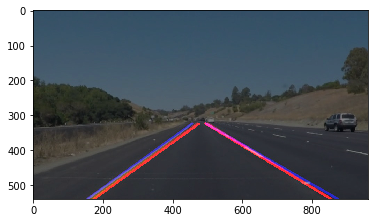

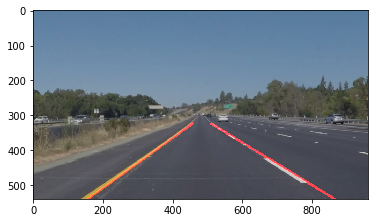

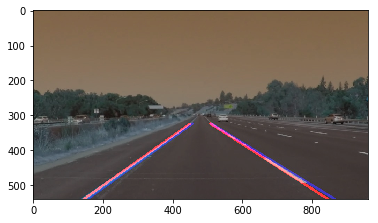

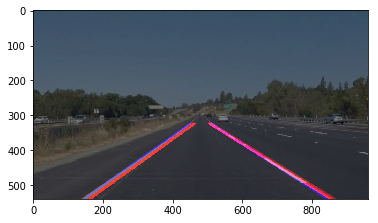

In [3]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

#reading in an image
#image = mpimg.imread(image_file)

def processImage(image):
    #create gray
    gray = grayscale(image)
    #blur
    blur_gray = gaussian_blur(gray, 5)
    #canny
    #reject pixels below lo_thresh "strong gradient" value
    lo_thresh = 50
    #acceot pixels above the hi_thresh gradient value
    hi_thresh = 150
    edges = canny(blur_gray, lo_thresh, hi_thresh)
    #region of interest
    imshape = image.shape
    vertices = np.array([[(0.16*imshape[1],imshape[0]),(0.45*imshape[1], 0.6*imshape[0]), (0.55*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #Hough
    #rho and theta are the distance and angular resolution of the grid in Hough space
    rho = 1
    theta = np.pi/180
    #threshold specifies the minimum number of votes (intersections in a grid cell)
    threshold = 20 # 15
    #minimum length of a line (in pixels) that is acceptable in the output
    min_line_len = 100 # 60
    #maximum distance (in pix) between segments to be connected into a single line
    max_line_gap = 180 # 20
    #lines is the lane lines
    lines = hough_lines(masked_edges, rho,theta,threshold,min_line_len,max_line_gap)  
    result = weighted_img(lines, image)
    
    return result

dirname = "test_images/"
image_list = os.listdir(dirname)

for each in image_list:
    frame_init = 1
    image_file = dirname + each
    image = mpimg.imread(image_file)
    lane_image = processImage(image)
    lane_file_name = os.path.splitext(image_file)[0] + '_annotated.jpg'
    cv2.imwrite(os.path.join(lane_file_name), lane_image)
    plt.figure()
    plt.imshow(lane_image)
        



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

Testing solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [4]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [5]:
def processImage(image):
    #create gray
    gray = grayscale(image)
    #blur
    blur_gray = gaussian_blur(gray, 5)
    #canny
    #reject pixels below lo_thresh "strong gradient" value
    lo_thresh = 50
    #acceot pixels above the hi_thresh gradient value
    hi_thresh = 150
    edges = canny(blur_gray, lo_thresh, hi_thresh)
    #region of interest
    imshape = image.shape
    vertices = np.array([[(0.16*imshape[1],imshape[0]),(0.45*imshape[1], 0.6*imshape[0]), (0.55*imshape[1], 0.6*imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edges = region_of_interest(edges, vertices)
    #Hough
    #rho and theta are the distance and angular resolution of the grid in Hough space
    rho = 1
    theta = np.pi/180
    #threshold specifies the minimum number of votes (intersections in a grid cell)
    threshold = 20 # 15
    #minimum length of a line (in pixels) that is acceptable in the output
    min_line_len = 100 # 60
    #maximum distance (in pix) between segments to be connected into a single line
    max_line_gap = 150
    #lines is the lane lines
    lines = hough_lines(masked_edges, rho,theta,threshold,min_line_len,max_line_gap)
    result = weighted_img(lines, image)

    return result

Let's try the one with the solid white lane on the right first ...

In [6]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:06<00:00, 35.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.99 s, sys: 709 ms, total: 3.7 s
Wall time: 7.09 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [7]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [8]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(processImage)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:20<00:00, 37.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 9.17 s, sys: 2.23 s, total: 11.4 s
Wall time: 21.3 s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  

Could be made more robust by adding a color selection, likely improved by using hsv vs rgb.  Could add more feedback mechanisms and calculate the error --something like a PID control.  

Where will your current algorithm be likely to fail?

Likely to fail in low light conditions, anywhere irregularly painted lanes or cross-traffic lanes are present.  

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

Needs to be more robust, early drafts showed it to be susceptible to div by zero errors in the challenge video.  This is telling me that my detections are sometimes completely off the mark --causing a slope of zero.  It does work for the white and yellow lanes.  I adjusted the algorithm to simply deal with null sets and div by zero, which is probably the only way to make this simplified lane-finding process work.

Initially I tried to make it kind of extensive and fancy, but had too many errors with code.  So I tried stripping it down to a simplified pipeline.






## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [10]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(processImage)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:14<00:00, 16.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.42 s, sys: 2 s, total: 8.41 s
Wall time: 16.4 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))